# Certaines langues sont-elles plus difficiles à analyser que d'autres ?

## **1) Objectif**
L’objectif de ce projet est d’analyser et de comprendre les raisons pour lesquelles des analyseurs syntaxiques partageant la mêm architecture et entraı̂nés sur la même quantité de données obtiennent des performances très différentes sur différentes langues. On peut observer ce phénomène dans la Table 1 qui présente les performances calculées à l’aide des mesures *LAS (Labeled Accuracy Score)* et *UAS (Unlabeled Accuracy Score)* obtenues par un analyseur sur 36 langues différentes.

Comme on le voit, les performances *(LAS/UAS)* présentent une très grande variablilité, variant de 47.28%/55.20% pour le turc à 79.47% 86.80% pour le hindi.

## **2) Analyseur et données d’apprentissage**
L’analyseur que vous utiliserez dans le cadre de ce projet est un analyseur en transition de type *Arc-eager*. Vous pouvez utiliser l’analyseur macaon qui vous a été présenté en cours ou un autre analyseur. Dans un premier temps, vous utiliserez une version délexicalisée de l’anlayseur, ce qui veut dire que la forme des mots n’est pas utilisée pour prédire la structure syntaxique. Les données sur lesquelles seront entraı̂nés et évalués les analyseurs sont disponibles sur le site du cours. Il s’agit de données provenant du projet *Universal Dependencies*. Elles ont été constituées de manière à ce que les données d’apprentissage soient équilibrées : 20000 mots à peu près pour chaque langue.

## **3) Analyse statistique**
Comme nous l’avons mentionné dans l’introduction, l’objectif du projet est d’expliquer pourquoi observe-t-on les différences indiquées dans la Table 1. Pour cela, nous nous placerons dans le cadre de la regression multiple. Nous supposerons que la variable à expliquer, notée $Y$ est le *LAS* calculé sur les corpus de test et que les variables explicatives $X_i$ sont diverses observations effectuées sur les corpus d’apprentissage. Votre objectif est de trouver des variables explicatives qui expliquent le plus possible la variabilité observée. Certaines variables explicatives sont observables directement sur les données annotées (longueur moyenne des phrases, des dépendances ...), tandis que d’autres sont plus difficiles à estimer, tel que la cohérence des annotations. On pourra s’inspirer pour cela de l’article suivant : *Divergences entre annotations dans le projet Universal Dependencies* et leur impact sur l’évaluation de l’étiquetage morpho-syntaxique que l’on trouvera sur le site du cours.

## **4) Ce qu'il faut faire**

* Refaire les expériences qui ont mené aux résultats de la Table 1 en utilisant l’analyseur par transition de votre choix. Le fait de réaliser les expériences permet de modifier les conditions d’apprentissage de l’analyseur (en particulier les features) afin de tester certaines hypothèses.
* Extraire à partir des données d’apprentissage des variables explicatives et réaliser la regression multiple. C’est le cœur du travail. Vous pouvez commencer cette partie sans avoir encore un analyseur qui fonctionne, en utilisant les résultats de la Table 1.
* Si vous trouvez des variables explicatives qui ne sont pas couvertes par les features utilisées par l’analyseur, modifiez le jeu de features (fichier fm dans le cas de macaon) et évaluez le nouvel analyseur.
* Rédiger un rapport de huit à dix pages décrivant le travail effectué ainsi que les réslutats obtenus.

# Import des modules et paramétrage du notebook

In [0]:
IS_DRIVE = True
BASE_PATH = "drive/My Drive/projet"
# BASE_PATH = "/home/hippo/GoogleDrive/univ/master-2/TAL/projet"

In [0]:
if IS_DRIVE:
    # install dependencies
    !pip install conllu ipython-autotime
    
    # mount drive
    from google.colab import drive
    drive.mount('drive')
    
    # change currrent directory path in order to import own modules
    import os
    os.chdir(BASE_PATH)

# Pour que les changements dans les modules importés soient pris en compte
%load_ext autoreload
%autoreload 2

# Pour afficher les figures dans le notebook
%matplotlib inline

# Pour afficher le temps d'exécution de chacune des cellules du notebook
%load_ext autotime

# extra modules
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score

# own modules
from corpus import parse_from_conllu
from features import FEATURE_NAMES

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 26.4 s


## Chargement des données

* todo décrire les structures utilisées

In [0]:
if IS_DRIVE:
    corpus_path = "data/corpus"
    scores_path = "data/scores.txt"
else:
    corpus_path = BASE_PATH + "/data/corpus"
    scores_path = BASE_PATH + "/data/scores.txt"

df = pd.read_csv(scores_path, sep=",", header=None)
df.columns = ['lang', 'las', 'uas']

lang_codes = df['lang']
scores = {'las': df['las'], 'uas': df['uas']}

corpus, features = parse_from_conllu(pathname_dir=corpus_path,
                                     lang_codes=lang_codes)

Parsing hi... done ! extracting features... done !
Parsing it... done ! extracting features... done !
Parsing ur... done ! extracting features... done !
Parsing pl... done ! extracting features... done !
Parsing ja... done ! extracting features... done !
Parsing no... done ! extracting features... done !
Parsing bg... done ! extracting features... done !
Parsing el... done ! extracting features... done !
Parsing ca... done ! extracting features... done !
Parsing sv... done ! extracting features... done !
Parsing fr... done ! extracting features... done !
Parsing pt... done ! extracting features... done !
Parsing ru... done ! extracting features... done !
Parsing da... done ! extracting features... done !
Parsing id... done ! extracting features... done !
Parsing en... done ! extracting features... done !
Parsing es... done ! extracting features... done !
Parsing uk... done ! extracting features... done !
Parsing ro... done ! extracting features... done !
Parsing ga... done ! extracting

* Comment utiliser les structures de données utilisées

In [0]:
phrases = corpus[0]
phrase = phrases[0]
mot = phrase[0]

print(f"lang_code\n\t{lang_codes[0]}\n")
print(f"première phrase\n\t{phrase}\n")
print(f"premier mot\n\t{mot}\n")
print(f"nombre de clés disponibles par mot\n\t{len(mot)}\n")
print(f"clés disponibles par mot\n\t{mot.keys()}\n")

lang_code
	hi

première phrase
	TokenList<इस, तरह, उसके, साथ, अब, कुल, ७५, विधायक, हो, गए, हैं, ।>

premier mot
	OrderedDict([('id', 1), ('form', 'इस'), ('lemma', 'यह'), ('upostag', 'DET'), ('xpostag', 'DEM'), ('feats', OrderedDict([('Case', 'Acc'), ('Number', 'Sing'), ('Person', '3'), ('PronType', 'Dem')])), ('head', 2), ('deprel', 'det'), ('deps', None), ('misc', OrderedDict([('ChunkId', 'NP'), ('ChunkType', 'child'), ('Translit', 'isa')]))])

nombre de clés disponibles par mot
	10

clés disponibles par mot
	odict_keys(['id', 'form', 'lemma', 'upostag', 'xpostag', 'feats', 'head', 'deprel', 'deps', 'misc'])

time: 8.61 ms


# Régression multiple pour expliquer les performances de l'analyseur syntaxique

## Features utilisés

In [0]:
FEATURE_NAMES

['number_of_sentences',
 'mean_length_of_a_sentence',
 'variance_length_of_a_sentence',
 'vocab_size',
 'mean_distance_to_head',
 'max_nested_dependency',
 'var_distance_to_head',
 'var_max_nested_dependency',
 'root_std',
 'non_projective',
 'DET',
 'NOUN',
 'ADP',
 'VERB',
 'ADJ',
 'PUNCT',
 'SCONJ',
 'PRON',
 'AUX',
 'CCONJ',
 'PROPN',
 'ADV',
 'NUM',
 'PART',
 'INTJ',
 'SYM',
 'X',
 '_']

time: 4.07 ms


In [0]:
print(len(FEATURE_NAMES))

28
time: 1.45 ms


## Mettre les données dans un pandas DataFrame pour faciliter les graphiques

In [0]:
df = pd.DataFrame(features, columns=FEATURE_NAMES)

df["las"] = pd.Series(scores["las"])
df["uas"] = pd.Series(scores["uas"])
df["lang_code"] = pd.Series(lang_codes)

time: 7.27 ms


In [0]:
df_lang_as_index = df.set_index("lang_code")
print(df_lang_as_index)

           number_of_sentences  mean_length_of_a_sentence  ...    las    uas
lang_code                                                  ...              
hi                       958.0                  20.887265  ...  79.47  86.80
it                       944.0                  22.625000  ...  78.38  82.15
ur                       766.0                  26.133159  ...  78.38  83.55
pl                      1995.0                  10.123810  ...  76.18  84.41
ja                       887.0                  22.555806  ...  75.74  85.60
no                      1261.0                  15.862807  ...  73.25  78.91
bg                      1459.0                  13.727210  ...  73.40  82.36
el                       842.0                  23.761283  ...  72.55  78.52
ca                       647.0                  31.020093  ...  72.06  79.70
sv                      1205.0                  16.604149  ...  71.10  77.36
fr                       790.0                  26.037975  ...  71.36  77.02

In [0]:
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr

# fig = make_subplots(rows=len(FEATURE_NAMES), cols=1, shared_xaxes=True)

score_to_track = "las"
hover_data = "lang_code"

for feature_idx, feature_name in enumerate(FEATURE_NAMES):
    print(abs(pearsonr(df[score_to_track], df[feature_name])[0]))
    fig = go.Figure(
        data=go.Scatter(
            x=df[score_to_track], #
            y=df[feature_name],   # 
            name=feature_name,    # 
            text=df[hover_data],  # on affiche le code du pays
            mode="markers",
            marker=dict(
                size=16,
                # color=np.random.randn(500),
                colorscale="Viridis",
                showscale=True
            )
        ),
        layout={
            'legend': {
                'orientation': 'v'
            },
            'xaxis_title': score_to_track,
            'yaxis_title': feature_name
        }
    )
    fig.show()

# fig.update_layout(height=3000, width=600)

0.3674007923941134


0.2798047612164181


0.07238224312455492


0.1507585354162391


0.019084597808203624


0.32242017606465506


0.03738999040274832


0.1496672716640906


0.23262030066413283


0.17512043548735426


0.26137517289112966


0.03665859116694931


0.5777818656781912


0.2554244513158279


0.12908785150372268


0.005604664276550098


0.32605087187662524


0.37876811575352043


0.46770584222730294


0.007378995013581829


0.3179612468220194


0.24638948006378342


0.07933203488851386


0.011562982081631729


0.1357537806114938


0.14446860058773073


0.13145156658729068


0.006651888816433191


time: 5.73 s


In [0]:
corrs = df.corr()

fig = go.Figure(
    data=go.Heatmap(
        z=corrs.values,
        x=list(corrs.columns),
        y=list(corrs.index),
        colorscale="Viridis"
    ),
    layout={
        'legend': {
            'orientation': 'v'
        },
        'title': "correlations coefficients"
    }
)

fig.show()

time: 143 ms


## Régressions utilisées

* Linéaire
* Ridge
* Lasso
* ElasticNet

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

def train_classifiers(features, scores):
    classifiers = dict()

    for score_name in scores.keys():
        classifiers[score_name] = {
            "linear_reg": LinearRegression(),
            "ridge": RidgeCV(),
            "lasso": LassoCV(),
            "elasticnet": ElasticNetCV([.01, .05, .1, .2, .5, 0.9])
        }

    for score_name, score in scores.items():
        for classifier_name, classifier in classifiers[score_name].items():
            classifier.fit(features, score)
    
    return classifiers

def real_scores(features, scores):
    classifiers = dict()

    for score_name in scores.keys():
        classifiers[score_name] = {
            "linear_reg": LinearRegression(),
            "ridge": Ridge(),
            "lasso": Lasso(),
            "elasticnet": ElasticNet()
        }
    results = dict()
    kf = KFold(n_splits=2)
    feat = np.array(features)
    for score_name, score in scores.items():
        for classifier_name, classifier in classifiers[score_name].items():
            real_score = 0
            for train_index, test_index in kf.split(feat):
                X_train, X_test = feat[train_index], feat[test_index]
                y_train, y_test = score[train_index], score[test_index]
                classifier.fit(X_train, y_train)
                real_score += classifier.score(X_test, y_test)
            real_score = real_score / kf.get_n_splits(feat)
            results[classifier_name + " " + score_name] = real_score
    
    return results


def plot_classifiers_scores(classifiers, features, scores):
    traces = []
    
    for score_name, score in scores.items():
        for classifier_name, classifier in classifiers[score_name].items():
            traces.append(
                go.Scatter(
                    y=[classifier.score(features, score)],
                    mode='markers',
                    name=f"{score_name} using {classifier_name}"
                )
            )

    # print(traces)

    fig = go.Figure(
        data=traces,
        layout={
            'legend': {
                'orientation': 'v'
            },
            'title': f"title",
            'xaxis_title': "xaxis title",
            'yaxis_title': f"yaxis title"
        }
    )
    fig.show()

time: 38.7 ms


## Entraînement

In [0]:
print(real_scores(features, scores))

{'linear_reg las': -20.866223840286466, 'ridge las': -7.59761559234458, 'lasso las': -7.756401223062083, 'elasticnet las': -7.585053208670049, 'linear_reg uas': -12.147757337414436, 'ridge uas': -5.346624963261739, 'lasso uas': -7.363468953253156, 'elasticnet uas': -6.586208390843396}
time: 54.5 ms


In [0]:
classifiers = train_classifiers(features, scores)
plot_classifiers_scores(classifiers, features, scores)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.



time: 609 ms


In [0]:
def plot_classifiers_coefficients(classifiers, features, scores):
    traces = []
    
    for feature_name, feature in zip(FEATURE_NAMES, features):
        traces.append(
            go.Scatter(
                y=feature,
                mode='markers',
                # name=FEATURE_NAMES
            )
        )

        fig = go.Figure(
            data=traces,
            layout={
                'legend': {
                    'orientation': 'v'
                },
                'title': f"title",
                'xaxis_title': "xaxis title",
                'yaxis_title': f"yaxis title"
            }
        )
        fig.show()

time: 4.27 ms


In [0]:
plot_classifiers_coefficients(classifiers, features, scores)

time: 6.34 s


## Table d'analyse de la variance (ANOVA)

las
-1.7457824516300866
['number_of_sentences' '-0.02098316307758985']
['mean_length_of_a_sentence' '-6.964836790041659']
['variance_length_of_a_sentence' '0.07131284850400452']
['vocab_size' '0.00020132360995351315']
['mean_distance_to_head' '-5.330906596870443']
['max_nested_dependency' '-8.495607698502514']
['var_distance_to_head' '-0.830217501681387']
['var_max_nested_dependency' '-1.7048530423526873']
['root_std' '0.2111010723764587']
['non_projective' '-18.852282299178736']
['DET' '6.475884718863596']
['NOUN' '10.780268529719036']
['ADP' '8.227794658120056']
['VERB' '-4.3888735120508455']
['ADJ' '5.732823335781133']
['PUNCT' '3.632470312678263']
['SCONJ' '7.083065621157644']
['PRON' '12.88672445398566']
['AUX' '10.704235696744092']
['CCONJ' '6.171082154290575']
['PROPN' '9.740065190236427']
['ADV' '9.359271431728438']
['NUM' '0.7100233866459654']
['PART' '16.842418572493056']
['INTJ' '-158.74967518906496']
['SYM' '27.972641510337933']
['X' '18.522748199924983']
['_' '1.3321941299

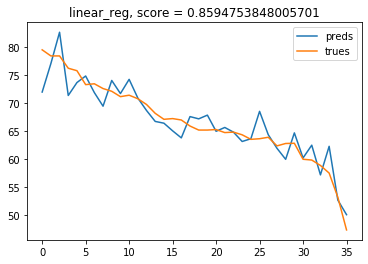

-0.08465411476275582
['number_of_sentences' '-0.01066239101191968']
['mean_length_of_a_sentence' '-0.4266328264183059']
['variance_length_of_a_sentence' '0.04037502243409108']
['vocab_size' '0.0007272580207882129']
['mean_distance_to_head' '-0.5008191674446264']
['max_nested_dependency' '0.1871288703280043']
['var_distance_to_head' '-0.3419837329837989']
['var_max_nested_dependency' '-0.6834777051764922']
['root_std' '-0.0572405597586334']
['non_projective' '-0.15109715492796455']
['DET' '-0.366693066140408']
['NOUN' '-0.10460741517143912']
['ADP' '2.4142281298613657']
['VERB' '-1.098658110989228']
['ADJ' '0.021667739548137943']
['PUNCT' '-1.4988465375892766']
['SCONJ' '-0.10826452281834276']
['PRON' '0.9411281272185618']
['AUX' '0.5623017163084489']
['CCONJ' '-0.3226545322317682']
['PROPN' '0.4439438834787659']
['ADV' '-0.5913210636193799']
['NUM' '-0.5381770561339605']
['PART' '0.8384025217111906']
['INTJ' '-0.03837216366050696']
['SYM' '-0.08336801157563314']
['X' '0.041248462976765

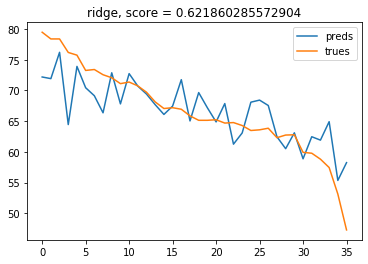

0.0
['number_of_sentences' '-0.0']
['mean_length_of_a_sentence' '0.0']
['variance_length_of_a_sentence' '0.0']
['vocab_size' '0.0']
['mean_distance_to_head' '0.0']
['max_nested_dependency' '0.0']
['var_distance_to_head' '0.0']
['var_max_nested_dependency' '0.0']
['root_std' '-0.0']
['non_projective' '-0.0']
['DET' '0.0']
['NOUN' '0.0']
['ADP' '0.0']
['VERB' '-0.0']
['ADJ' '0.0']
['PUNCT' '0.0']
['SCONJ' '0.0']
['PRON' '0.0']
['AUX' '0.0']
['CCONJ' '-0.0']
['PROPN' '0.0']
['ADV' '-0.0']
['NUM' '-0.0']
['PART' '-0.0']
['INTJ' '-0.0']
['SYM' '0.0']
['X' '-0.0']
['_' '-0.0']


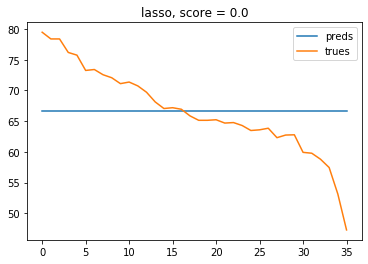

-5.731579277672946e-05
['number_of_sentences' '-0.002077311004489835']
['mean_length_of_a_sentence' '0.0']
['variance_length_of_a_sentence' '0.0']
['vocab_size' '0.00047246880674140987']
['mean_distance_to_head' '-0.0']
['max_nested_dependency' '0.0']
['var_distance_to_head' '-0.0']
['var_max_nested_dependency' '0.0']
['root_std' '-0.0']
['non_projective' '-0.0']
['DET' '0.0']
['NOUN' '-0.0']
['ADP' '0.0']
['VERB' '-0.0']
['ADJ' '0.0']
['PUNCT' '-0.0']
['SCONJ' '0.0']
['PRON' '0.0']
['AUX' '0.0']
['CCONJ' '-0.0']
['PROPN' '0.0']
['ADV' '-0.0']
['NUM' '-0.0']
['PART' '-0.0']
['INTJ' '-0.0']
['SYM' '0.0']
['X' '-0.0']
['_' '-0.0']


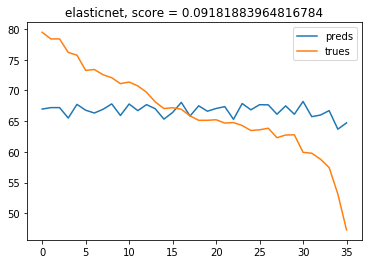

uas
-0.9825977168129968
['number_of_sentences' '-0.01157874226938025']
['mean_length_of_a_sentence' '-3.5008722866501927']
['variance_length_of_a_sentence' '0.02692294977552724']
['vocab_size' '0.0009616597737932644']
['mean_distance_to_head' '-1.5635217645262016']
['max_nested_dependency' '-6.653189802732378']
['var_distance_to_head' '-0.5747514152256297']
['var_max_nested_dependency' '-1.0260575942701688']
['root_std' '-1.0862686320688717']
['non_projective' '-9.623508151278301']
['DET' '3.4998833165750742']
['NOUN' '7.680993685787572']
['ADP' '5.379515412746615']
['VERB' '-9.304082544034417']
['ADJ' '0.11927560946052396']
['PUNCT' '0.13250938441776508']
['SCONJ' '-1.2666237740932276']
['PRON' '6.80557461806291']
['AUX' '5.584543028885026']
['CCONJ' '8.971630135056246']
['PROPN' '7.269668036949969']
['ADV' '6.959314330064398']
['NUM' '-11.256840520041708']
['PART' '12.950971663051261']
['INTJ' '-89.22206081660995']
['SYM' '29.52171525913361']
['X' '12.532686562752094']
['_' '0.140454

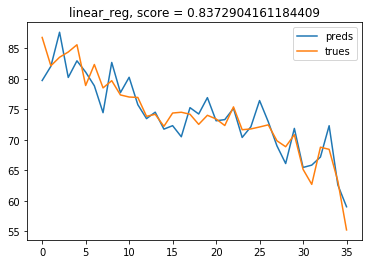

-0.05291316527833569
['number_of_sentences' '-0.004474431056223693']
['mean_length_of_a_sentence' '-0.26548665492297374']
['variance_length_of_a_sentence' '0.02349272749023612']
['vocab_size' '0.0007137046277421177']
['mean_distance_to_head' '-0.28754612740867713']
['max_nested_dependency' '0.11748966454784027']
['var_distance_to_head' '-0.20252461587241655']
['var_max_nested_dependency' '-0.20004308840055707']
['root_std' '-0.31317503776286815']
['non_projective' '-0.08452811411252713']
['DET' '-0.23438785086663683']
['NOUN' '-0.24453170541991964']
['ADP' '2.4417199750786955']
['VERB' '-1.4802851701107347']
['ADJ' '0.0018021556528033944']
['PUNCT' '-1.4064163126183535']
['SCONJ' '0.09155992638342525']
['PRON' '0.8915116198072818']
['AUX' '0.9674528645349458']
['CCONJ' '-0.25409116506434215']
['PROPN' '0.300163800150433']
['ADV' '-0.23334437402376074']
['NUM' '-0.6186948392038154']
['PART' '0.584974174362249']
['INTJ' '-0.032602532616177494']
['SYM' '-0.04768144689293562']
['X' '-0.396

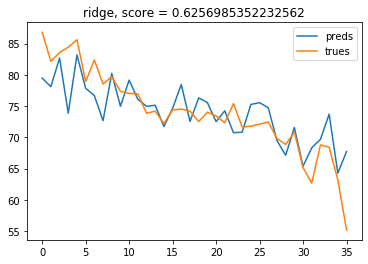

5.715121958779259e-06
['number_of_sentences' '-0.0']
['mean_length_of_a_sentence' '0.0']
['variance_length_of_a_sentence' '0.0']
['vocab_size' '0.00016002341484581926']
['mean_distance_to_head' '0.0']
['max_nested_dependency' '0.0']
['var_distance_to_head' '0.0']
['var_max_nested_dependency' '0.0']
['root_std' '-0.0']
['non_projective' '-0.0']
['DET' '0.0']
['NOUN' '0.0']
['ADP' '0.0']
['VERB' '-0.0']
['ADJ' '0.0']
['PUNCT' '-0.0']
['SCONJ' '0.0']
['PRON' '0.0']
['AUX' '0.0']
['CCONJ' '-0.0']
['PROPN' '0.0']
['ADV' '-0.0']
['NUM' '-0.0']
['PART' '-0.0']
['INTJ' '-0.0']
['SYM' '0.0']
['X' '-0.0']
['_' '-0.0']


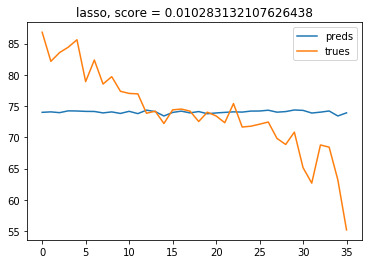

5.351049728242869e-06
['number_of_sentences' '-0.0']
['mean_length_of_a_sentence' '0.0']
['variance_length_of_a_sentence' '0.0']
['vocab_size' '0.00014982939239080033']
['mean_distance_to_head' '0.0']
['max_nested_dependency' '0.0']
['var_distance_to_head' '0.0']
['var_max_nested_dependency' '0.0']
['root_std' '-0.0']
['non_projective' '-0.0']
['DET' '0.0']
['NOUN' '0.0']
['ADP' '0.0']
['VERB' '-0.0']
['ADJ' '0.0']
['PUNCT' '-0.0']
['SCONJ' '0.0']
['PRON' '0.0']
['AUX' '0.0']
['CCONJ' '-0.0']
['PROPN' '0.0']
['ADV' '-0.0']
['NUM' '-0.0']
['PART' '-0.0']
['INTJ' '-0.0']
['SYM' '0.0']
['X' '-0.0']
['_' '-0.0']


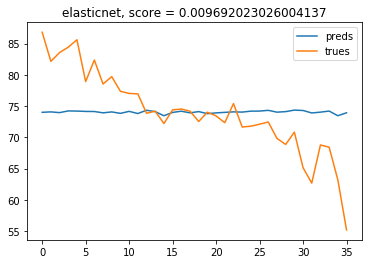

time: 1.71 s


In [0]:
import matplotlib.pyplot as plt

X = features
Y = scores
x_range = np.arange(0, len(X))

for y_name, y in Y.items():
    print(y_name)
    for clf_name, clf in classifiers[y_name].items():
        y_pred = clf.predict(X)
        #def get_line(x):
        #    return clf.intercept_ + x @ clf.coef_
        #plt.plot(x_range, get_line(X), label="preds_line")
        shit = np.vstack((FEATURE_NAMES, clf.coef_.astype(str))).T
        print(clf.coef_.mean())
        for i in shit:
          print(i)
        plt.plot(x_range, y_pred, label="preds")
        plt.plot(x_range, y, label="trues")
        plt.title(f"{clf_name}, score = {clf.score(X, y)}")
        
        plt.legend()
        plt.show()

# Analyse en utilisant l'API `statsmodels`

In [0]:
from statsmodels.api import OLS

for y_name, y in Y.items():
    model = OLS(y, X).fit()
    print(model.summary())
    print('\n' * 5)

                                 OLS Regression Results                                
Dep. Variable:                    las   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              179.9
Date:                Sun, 22 Dec 2019   Prob (F-statistic):                    1.96e-09
Time:                        15:06:58   Log-Likelihood:                         -89.222
No. Observations:                  36   AIC:                                      232.4
Df Residuals:                       9   BIC:                                      275.2
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------